# COVID-ResNet implementation in Pytorch

In this notebook, we attempt to implement the [COVID-ResNet paper](http://arxiv.org/abs/2003.14395) in `Pytorch` and using the `Fast.ai` library. 

Opposed to the original paper, the network is trained to classify between `COVID`, `Pneumonia` and `normal` using the original `COVIDx` dataset. 

In [76]:
import pandas as pd
import numpy as np
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
#from model_utils import custom_path_load, custom_path_save

# Data

We use two different datasets:

* https://github.com/ieee8023/covid-chestxray-dataset, containing 99 COVID, 17 bacterial and 11 viral chest x-ray images. 

*  https://www.kaggle.com/c/rsna-pneumonia-detection-challenge containing 1345 viral and 2530 bacterial images.  

Images have to be preprocessed a-priori using this attached [noteboook](./data_discovery.ipynb).

Processed images are stored in `data/COVIDx`.  We import the training and testing `Dataframes` to select the correspondent labels. 

In [3]:
train_path = 'data/COVIDx/train'
df_train = pd.read_pickle('covidX_train.pkl')
df_test = pd.read_pickle('covidX_test.pkl')
df_train.head()

,name,label
0,data/COVIDx/train/auntminnie-a-2020_01_28_23_5...,covid
1,data/COVIDx/train/auntminnie-b-2020_01_28_23_5...,covid
2,data/COVIDx/train/auntminnie-c-2020_01_28_23_5...,covid
3,data/COVIDx/train/auntminnie-d-2020_01_28_23_5...,covid
4,data/COVIDx/train/nejmc2001573_f1a.png,covid


# Training

Using a `resnet50` model. The model is `freezed` by default, resulting in `2,5M` training parameters. The model is trained on three stages. 


## Data augmentation

Data augmentation helps in creating newer examples by applying different transformation randomly to the available training images. In this work, the transformation that we used included vertical flips of the training images, random rotation of the images (maximum rotation angle was 15 degree), and lighting conditions. Data augmentation increases the size of input training data along with the model regularization and hence improving generalization of the training model. Only the training data was augmented, and the test time augmentation was not explored.

In [4]:
transforms = get_transforms(do_flip=True, 
                            flip_vert=True,
                            max_rotate=15)

## Model utils

In [5]:
model_name = 'resnet_covid_implementation'

model_path = os.path.join('models', model_name)

# create the models folder
if os.path.exists('models') is False:
    os.mkdir('models')

# create the current model folder
if os.path.exists(model_path) is False:
    os.mkdir(model_path)
   

def custom_path_save(self, 
                     name:PathOrStr, 
                     path='models', 
                     return_path:bool=False, 
                     with_opt:bool=True):
    '''
    Save model and optimizer state (if `with_opt`) 
    with `name` to `self.model_dir`."
    '''
    if path == '': 
        path = self.path/self.model_dir/f'{name}.pth'
    else: 
        path = f'{path}/{name}.pth'
    if not with_opt: 
        state = get_model(self.model).state_dict()
    else: 
        state = {'model': get_model(self.model).state_dict(), 'opt':self.opt.state_dict()}
    torch.save(state, path)
    
    if return_path: 
        return path

def custom_path_load(self, 
                     name:PathOrStr, 
                     path='models', 
                     device:torch.device=None, 
                     strict:bool=True, 
                     with_opt:bool=None,
                     purge=False):
    """
    Load model and optimizer state (if `with_opt`) `name` 
    from `self.model_dir` using `device`."

    """
    if device is None: 
        device = self.data.device
    if path=='': 
        path = self.path/self.model_dir/f'{name}.pth'
    else: 
        path = f'{path}/{name}.pth'
    
    state = torch.load(path, map_location=device) 
    if set(state.keys()) == {'model', 'opt'}:
        get_model(self.model).load_state_dict(state['model'], strict=strict)
        if ifnone(with_opt,True):
            if not hasattr(self, 'opt'): 
                opt = self.create_opt(defaults.lr, self.wd)
            try:    
                self.opt.load_state_dict(state['opt'])
            except: 
                pass
    else:
        if with_opt: 
            warn("Saved filed doesn't contain an optimizer state.")
        get_model(self.model).load_state_dict(state, strict=strict)
    return self


## Stage 1

The input images are resized to 128x128x3 pixels and the COVID-ResNet are tuned in 2 steps:

1) only the newly added head of the network is trained while preserving the ImageNet weights for the rest of the body with a learning rate of 1e-3 for 3 epochs. 

2) the whole network is fine-tuned (both the body and the head of the model) using discriminative learning rate proposed in [9] for 5 epochs. 


In [6]:
data = ImageDataBunch.from_df(path='.', 
                              df=df_train,
                              valid_pct=0.25,
                              test=None,
                              ds_tfms=transforms, 
                              bs=32, 
                              size=128, 
                              num_workers=8).normalize(imagenet_stats)

#show size of our datasets
print("TRAIN:", len(data.train_ds),
      "VALIDATION:", len(data.valid_ds))

precision = Precision(average='macro')
AUC = AUROC()
learn = cnn_learner(data, models.resnet50, metrics=(accuracy, precision, error_rate, AUC)) 

# data.show_batch(rows=3, figsize=(10,10))

TRAIN: 12507 VALIDATION: 4169


In [7]:
learn.freeze()
learn.fit_one_cycle(3, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time
0,0.472669,0.415782,0.894219,nan,0.105781,0.044301,01:15
1,0.297933,0.243807,0.919645,0.946529,0.080355,0.029581,01:15
2,0.237206,0.224990,0.919165,0.946053,0.080835,0.027659,01:16


epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


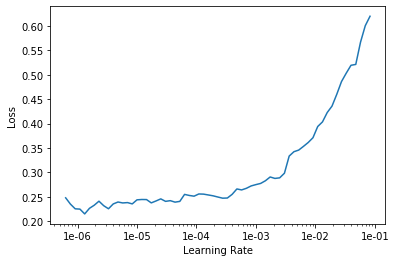

In [10]:
# find the best learning rate with discriminataive learning rate
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(5, max_lr=slice(1e-06,1e-02))
learn.save(os.path.join(model_name, model_name + '_stage1'))

epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time
0,0.345934,0.297545,0.898297,0.935151,0.101703,0.030709,01:16
1,0.350738,0.545873,0.917006,0.946290,0.082994,0.035818,01:16
2,0.223248,0.220476,0.932358,0.954956,0.067642,0.021280,01:15
3,0.210891,0.187350,0.931398,0.954231,0.068602,0.019808,01:15
4,0.191939,0.187155,0.930679,0.887209,0.069321,0.019732,01:15


## Stage 2

1) The head of the model resulting from stage-I is further fine-tuned with images of size 224x224x3 in the first step with learning rate of 1e-4 for 3 epochs. 

2) In the second step, the whole network is further fine-tuned for 5 epochs with discriminative learning rate as before. 


In [22]:
data = ImageDataBunch.from_df(path='.', 
                              df=df_train,
                              valid_pct=0.25,
                              test=None,
                              ds_tfms=transforms, 
                              bs=32, 
                              size=224, 
                              num_workers=8).normalize(imagenet_stats)

#show size of our datasets
print("TRAIN:", len(data.train_ds),
      "VALIDATION:", len(data.valid_ds))

precision = Precision(average='macro')
AUC = AUROC()
learn = cnn_learner(data, models.resnet50, metrics=(accuracy, precision, error_rate, AUC))

# data.show_batch(rows=3, figsize=(10,10))

TRAIN: 12507 VALIDATION: 4169


In [ ]:
# load previous weights with 128 x 128 images
learn.load(os.path.join(model_name, model_name + '_stage1'))

# train for 3 epochs
learn.freeze() # probably unnecessaryZ
learn.fit_one_cycle(3, max_lr=1e-04)

epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


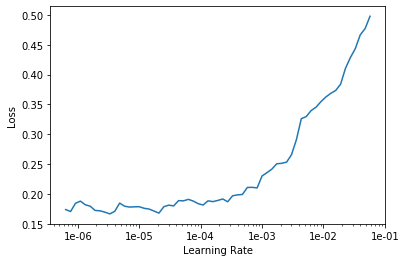

In [24]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(5, max_lr=slice(1e-06,1e-02))
learn.save(os.path.join(model_name, model_name + '_stage2'))

epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time
0,0.157222,5.762094,0.934517,0.698703,0.065483,0.018725,01:30
1,0.176794,14.851979,0.946030,0.930957,0.053970,0.015792,01:30
2,0.178539,0.564443,0.945071,0.939560,0.054929,0.016251,01:30
3,0.149509,0.171283,0.947469,0.925883,0.052531,0.019107,01:31
4,0.137970,0.150033,0.947949,0.943058,0.052051,0.016917,01:31


In [26]:
learn.fit_one_cycle(5, max_lr=slice(1e-06,1e-02))
learn.save(os.path.join(model_name, model_name + '_stage2'))

epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time
0,0.157222,5.762094,0.934517,0.698703,0.065483,0.018725,01:30
1,0.176794,14.851979,0.946030,0.930957,0.053970,0.015792,01:30
2,0.178539,0.564443,0.945071,0.939560,0.054929,0.016251,01:30
3,0.149509,0.171283,0.947469,0.925883,0.052531,0.019107,01:31
4,0.137970,0.150033,0.947949,0.943058,0.052051,0.016917,01:31


## Stage 3

ast stage, the whole network is further fine-tuned with input images of size 229x229x3 for 25 epochs. In this case we use discriminative learning rates where the earliest layer was trained with a learning rate of 1e-6 and the last layer was trained with a learning rate of 1e-4. All the layers in between were trained with equidistance learning rates between these two values.
Training

In [71]:
data = ImageDataBunch.from_df(path='.', 
                              df=df_train,
                              valid_pct=0.25,
                              test=None,
                              ds_tfms=transforms, 
                              bs=32, 
                              size=229, 
                              num_workers=8).normalize(imagenet_stats)

#show size of our datasets
print("TRAIN:", len(data.train_ds),
      "VALIDATION:", len(data.valid_ds))

precision = Precision(average='macro')
AUC = AUROC()
learn = cnn_learner(data, models.resnet50, metrics=(accuracy, precision, error_rate, AUC))

TRAIN: 12507 VALIDATION: 4169


In [72]:
# load weights from stage 2
learn.load(os.path.join(model_name, model_name + '_stage2'))

# apply inbalance
import torch.nn as nn
Learner.crit = nn.CrossEntropyLoss(weight=torch.tensor([1, 0.05, 0.05]))

# train for 3 epochs

learn.freeze() # probably unnecessaryZ
learn.fit_one_cycle(10, max_lr=1e-04)

epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time
0,0.148248,0.315586,0.953946,0.969162,0.046054,0.018516,01:34
1,0.147710,0.247595,0.955625,0.937250,0.044375,0.015246,01:34
2,0.160633,0.525619,0.950828,0.949807,0.049172,0.016717,01:34
3,0.134670,0.118303,0.955385,0.970100,0.044615,0.016266,01:34
4,0.137094,0.208702,0.955625,0.942757,0.044375,0.017846,01:34
5,0.138902,1.189591,0.954665,0.950175,0.045335,0.014708,01:34
6,0.133596,0.178683,0.955625,0.941576,0.044375,0.015874,01:34
7,0.140367,0.121203,0.956105,0.955576,0.043895,0.015675,01:34
8,0.129280,2.106376,0.953706,0.939017,0.046294,0.016044,01:34
9,0.128727,0.117074,0.956824,0.971052,0.043176,0.015657,01:34


epoch,train_loss,valid_loss,accuracy,precision,error_rate,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


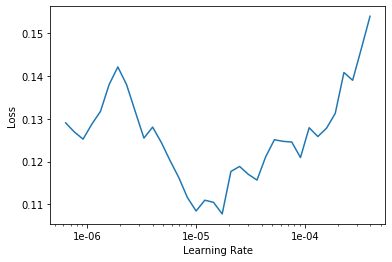

In [61]:
# discriminative lr: earliest layers: 1e-06, last: 1e-04
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-06,1e-02))
learn.save(os.path.join(model_name, model_name + '_stage3'))

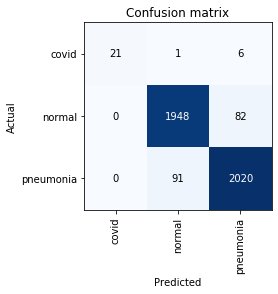

In [73]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Prediction on test set

Test images are in `df_test` dataframe. We evaluate the performance of the method in terms of the sensitivity and predictive positive value to compare with COVID-Net results as reported [here](https://arxiv.org/pdf/2003.09871.pdf).

In [80]:
df_test.head(20)

,name,label
0,data/COVIDx/test/1.CXRCTThoraximagesofCOVID-19...,covid
1,data/COVIDx/test/1.CXRCTThoraximagesofCOVID-19...,covid
2,data/COVIDx/test/1.CXRCTThoraximagesofCOVID-19...,covid
3,data/COVIDx/test/1.CXRCTThoraximagesofCOVID-19...,covid
4,data/COVIDx/test/covid-19-pneumonia-evolution-...,covid
5,data/COVIDx/test/53EC07C9-5CC6-4BE4-9B6F-D7B0D...,covid
6,data/COVIDx/test/covid-19-caso-70-1-PA.png,covid
7,data/COVIDx/test/4e43e48d52c9e2d4c6c1fb9bc1544...,covid
8,data/COVIDx/test/covid-19-pneumonia-53.png,covid
9,data/COVIDx/test/fff49165-b22d-4bb4-b9d1-d5d62...,covid


## Predict images

In [90]:
classes = ['covid19', 'normal', 'pneumonia']
test_images = df_test['name']
labels = df_test['label']
EVAL_CASES = len(labels)
# PRED_TH = 0.9


# convert labels to numbers to compare
l2n = {'covid': 0, 'pneumonia': 2, 'normal': 1}
num_labels = [l2n[l] for l in labels]

# compute results
results = {}
predictions = []
for f, l in zip(test_images[:EVAL_CASES], labels[:EVAL_CASES]):
    pred = learn.predict(open_image(f))
    # i = 0 if pred[2][0] >= PRED_TH else np.argmax(pred[2][1:].numpy()) + 1
    i = np.argmax(pred[2].numpy())
    # print('label:', l, pred, i)
    results[f] = classes[i] 
    predictions.append(i)
    


## Compute stats

,class,num samples,sensitivity,precision
0,covid19,10,0.500000,0.714286
1,normal,886,0.985327,0.968923
2,pneumonia,959,0.969760,0.982049


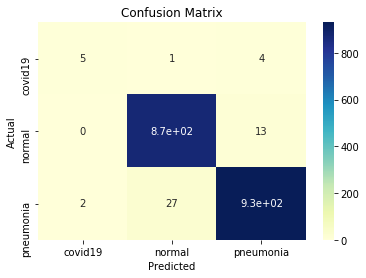

In [91]:
cm = confusion_matrix(num_labels[:EVAL_CASES], predictions, labels = [0, 1, 2])
ax = plt.subplot()
sns.set_color_codes("pastel")
sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu")
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);


# count elements per class
elements_x_class = [np.sum(num_labels[:EVAL_CASES] == (np.ones(EVAL_CASES) * l))
                    for l in range(3)]

# global accuracy
g_acc = accuracy_score(num_labels[:EVAL_CASES], predictions)
# sensitivity x clas
recall_scores = recall_score(num_labels[:EVAL_CASES], predictions, average=None)
# precision x class
precision_scores = precision_score(num_labels[:EVAL_CASES], predictions, average=None)
d_r = pd.DataFrame({'class': classes, 
                    'num samples': elements_x_class, 
                    'sensitivity': recall_scores, 
                    'precision': precision_scores})
d_r.head()